### Import lib

In [1]:
import os
os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from treeconfigparser import TreeConfigParser
import joblib

import models.seg as sm
from data.Data import Data
from include.loss import pixel_weighted_cross_entropy


In [2]:
def baseline_10p_mass(x_valid):
    rt = 0.9
    x_valid = x_valid.numpy()
    x_save = x_valid.copy()
    x_valid[x_valid<0] = 0    
    x_valid = x_valid.reshape(-1, x_valid.shape[1]*x_valid.shape[2])
    evo_diff_cummass_rt = np.sort(x_valid, axis=1).cumsum(axis=1) - rt * np.sum(
        x_valid, axis=1
    ).reshape(-1, 1)
    N_drop_val = (
        np.where(evo_diff_cummass_rt < 0, evo_diff_cummass_rt, -np.inf).argmin(
            axis=1
        )
    )
    x_valid[
        x_valid.argsort(axis=1).argsort(axis=1) < N_drop_val.reshape(-1, 1)
    ] = 0
    pred_baseline_2 = x_valid.reshape(-1, x_save.shape[1], x_save.shape[2], 1)
    pred_baseline_2[pred_baseline_2>0] = 1
    return pred_baseline_2

### GPU Memory

In [3]:
gpu_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [4]:
tf.config.experimental.get_memory_info('GPU:0')["peak"] / 1e6

2022-07-04 17:34:57.222634: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.0

2022-07-04 17:34:57.671620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14544 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


### Case choices

In [70]:
path_res = "/cerea_raid/users/dumontj/dev/coco2/dl/res"
dataset = "seg_PGIPW_DA"
weights = "seg_PGIPW_DA"

In [71]:
def get_data(ds: str, scaler):
    config = TreeConfigParser()
    config.readfiles(os.path.join(path_res, ds, "config.cfg"))
    shuffle_indices = np.fromfile(os.path.join(path_res, ds, "shuffle_indices.bin")).astype(np.int64)
    data = Data(config, shuffle_indices)
    data.prepare_input(scaler)
    data.prepare_output()
    print("xco2 valid mean", np.mean(data.y.valid[0]))
    return data

In [72]:
def get_model(path_w: str):
    model = keras.models.load_model(os.path.join(path_w, "weights_cp_best.h5"), compile=False)
    model.compile('adam', loss=pixel_weighted_cross_entropy)    
    return model

def get_scaler(path_w: str):
    scaler = joblib.load(os.path.join(path_w, "scaler.save"))
    return scaler

### Download model + data 

In [73]:
full_path_w = os.path.join("/cerea_raid/users/dumontj/dev/coco2/dl/res", weights)
model = get_model(full_path_w)
scaler = get_scaler(full_path_w)
data = get_data(dataset, scaler)

mean, var xco2 402.8727 13.941546
data.inp.train.shape[0] (24194, 160, 160, 1)
data.out.train.shape (24194, 160, 160, 1)
xco2 valid mean 0.2000730586927321


## Evaluation

In [74]:
x_valid = tf.convert_to_tensor(data.x.valid[0], np.float32)
y_valid = tf.convert_to_tensor(data.y.valid, np.float32)
pred_valid = tf.convert_to_tensor(model.predict(x_valid), np.float32)
loss_valid = model.evaluate(x=x_valid, y=y_valid, batch_size=64)
data.y.get_trace(xr.open_dataset(os.path.join(data.dir_dataset, "dataset.nc")), data.eval_shuffler)


95/95 [==============================] - 4s 37ms/step - loss: 0.2159


In [125]:
ds = xr.open_dataset(os.path.join(data.dir_dataset, "dataset.nc"))
xco2 = np.expand_dims(ds.xco2.values, -1)
[xco2_train, xco2_valid, xco2_test] = data.eval_shuffler.train_valid_test_split(xco2)

#### Baseline

In [10]:
zeros_valid = tf.zeros_like(pred_valid, np.float32)
print("zeros_everywhere baseline:", model.compute_loss(y=y_valid, y_pred=zeros_valid).numpy())
baseline_10p_valid = tf.convert_to_tensor(baseline_10p_mass(x_valid), np.float32)
print("10% of the mass baseline:", model.compute_loss(y=y_valid, y_pred=baseline_10p_valid).numpy())

zeros_everywhere baseline: 2.6780105
10% of the mass baseline: 2.911642


### Random output

In [17]:
idx = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))

0.13189572


Text(0.5, 1.0, 'pred')

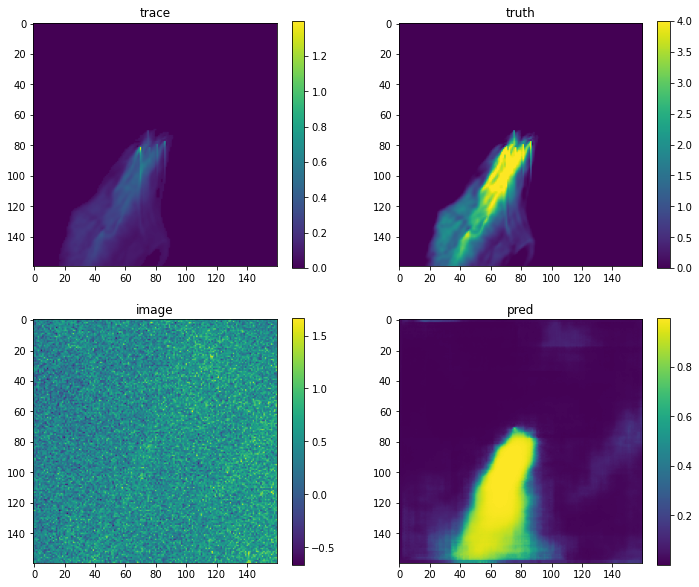

In [18]:

print(model.compute_loss(y=y_valid[idx:idx+1], y_pred=pred_valid[idx:idx+1]).numpy())

plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(data.y.trace_valid[idx]))
plt.colorbar()
plt.title("trace")
#plt.savefig("nb/sim/fig/seg_pw-trace.png", transparent=True)

plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(data.y.valid[idx]))
plt.colorbar()
plt.title("truth")
#plt.savefig("nb/sim/fig/seg_pw-truth.png")

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(data.x.valid[0][idx]))
plt.colorbar()
plt.title("image")
#plt.savefig("nb/sim/fig/seg_pw-input.png")

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[0][idx], 0))[0]))
plt.colorbar()
plt.title("pred")
#plt.savefig("nb/sim/fig/seg_pw-prediction.png")

### Worst evaluation

tf.Tensor(0.06977987, shape=(), dtype=float32)


Text(0.5, 1.0, 'pred')

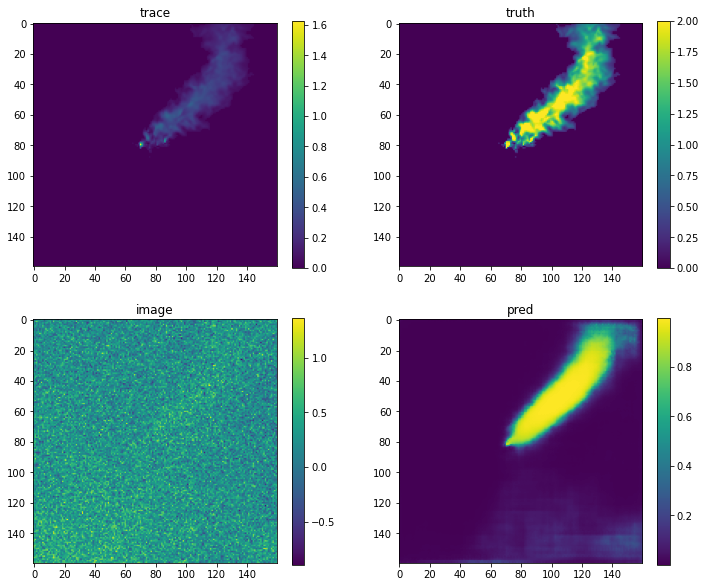

In [15]:
idx_worst = np.argmax(loss_valid)
print(model.compute_loss(y=y_valid[idx_worst:idx_worst+1], y_pred=pred_valid[idx_worst:idx_worst+1]))

plt.figure(figsize=(12,10))

plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(data.trace_valid[idx_worst]))
plt.colorbar()
plt.title("trace")

plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(data.y_valid[idx_worst]))
plt.colorbar()
plt.title("truth")

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(data.x_valid[0][idx_worst]))
plt.colorbar()
plt.title("image")

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(model(tf.expand_dims(data.x_valid[0][idx_worst], 0))[0]))
plt.colorbar()
plt.title("pred")

### Best evaluation

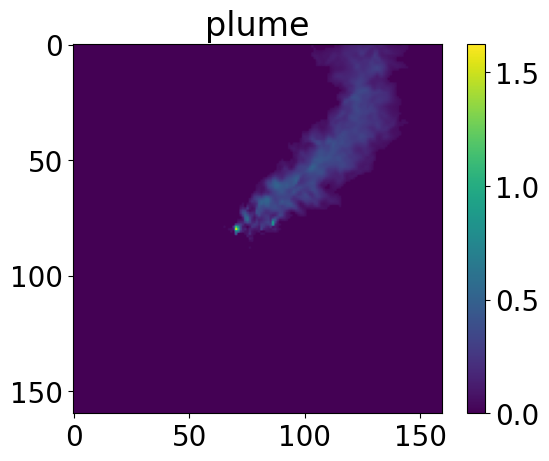

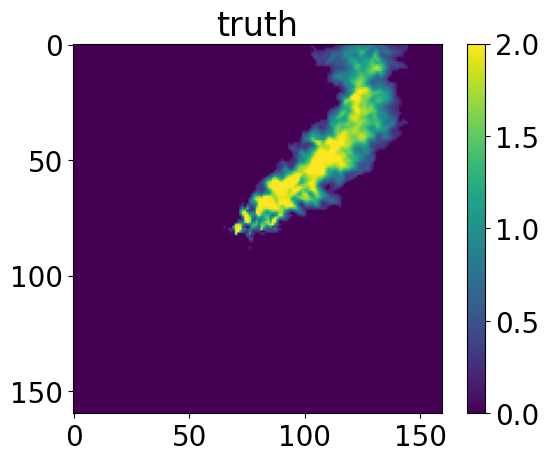

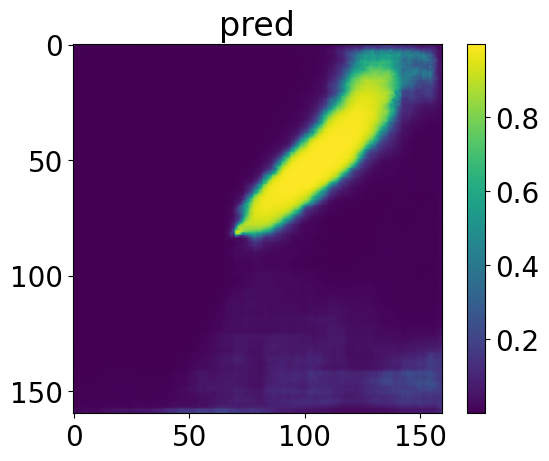

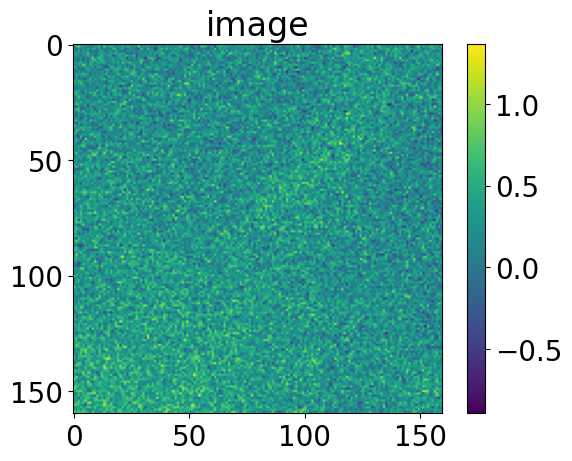

In [63]:
idx_best = np.argmin(loss_valid)

plt.figure()
plt.imshow(np.squeeze(data.trace_valid[idx_best]))
plt.colorbar()
plt.title("Plume")
plt.savefig("nb/sim/fig/seg_pw-trace.png", transparent=True)

plt.figure()
plt.imshow(np.squeeze(data.y_valid[idx_best]))
plt.colorbar()
plt.title("Truth")
plt.savefig("nb/sim/fig/seg_pw-truth.png")

plt.figure()
plt.imshow(np.squeeze(model(tf.expand_dims(data.x_valid[0][idx_best], 0))[0]))
plt.colorbar()
plt.title("Prediction")
plt.savefig("nb/sim/fig/seg_pw-prediction.png")

plt.figure()
plt.imshow(np.squeeze(data.x_valid[0][idx_best]))
plt.colorbar()
plt.title("Input")
plt.savefig("nb/sim/fig/seg_pw-input.png")

### Histogram perf.

In [58]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
font = {'size'   : 20}
plt.rc('font', **font)

In [59]:
y_trace = data.trace_valid.flatten()
y_weight = data.y_valid.flatten()
y_bin = tf.cast(data.y_valid > 0, data.y_valid.dtype).numpy().flatten()


#pred_valid = model.predict(tf.convert_to_tensor(data.x_valid[0], np.float32), batch_size=64)
y_pred = pred_valid.numpy().flatten()

distance_to_truth = np.abs(y_pred-y_bin)

In [60]:
df = pd.DataFrame({'y_true': y_bin, 'y_pred': y_pred, 'y_trace': y_trace,
                   'dtt': distance_to_truth})

In [61]:
df_pos = df.copy()
df_pos = df_pos[df_pos["y_trace"]>0]
df_pos["y_trace_bin"] = pd.qcut(df_pos["y_trace"], 6, precision=2)

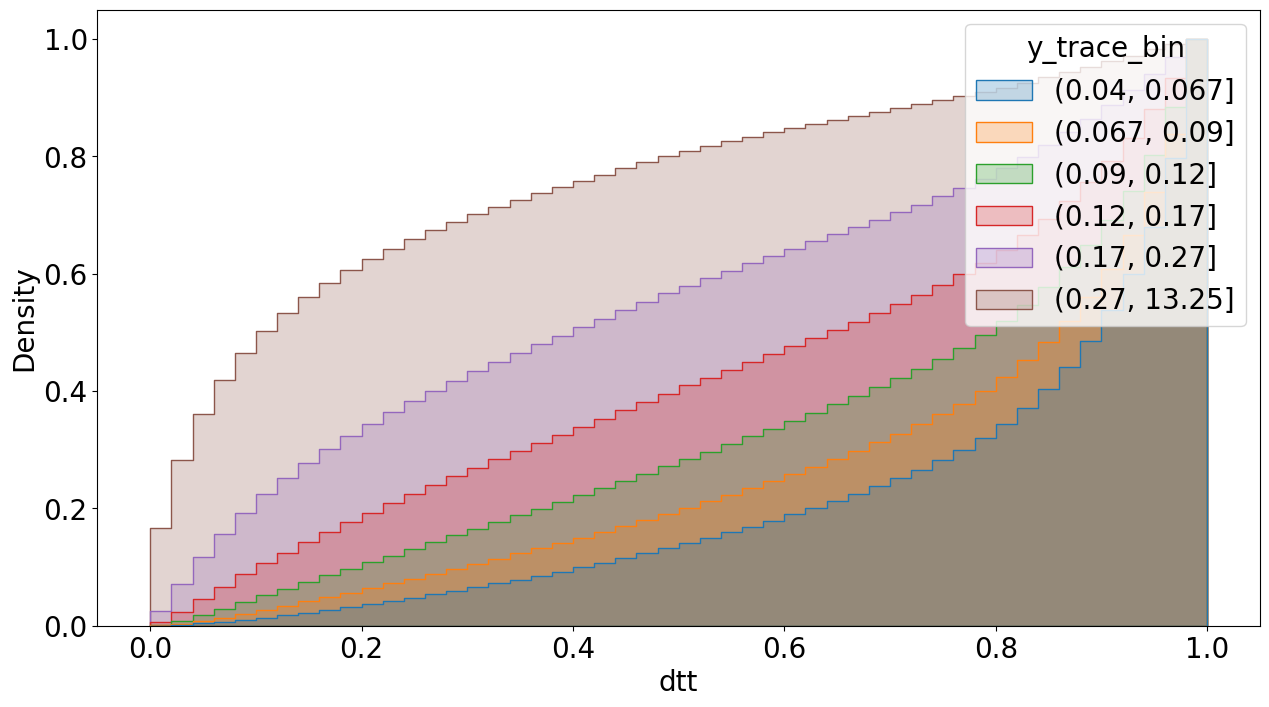

In [62]:
plt.figure(figsize=(15,8))
sns.histplot(
    data=df_pos,
    x="dtt",
    hue="y_trace_bin",
    log_scale=False,
    element="step",
    cumulative=True,
    stat="density",
    common_norm=False,
    bins=50,
)
plt.savefig(os.path.join("nb/sim/fig",dataset + "_cum_hist_dtt_pos.png"), transparent=True)

In [ ]:
df_neg = df.copy()
df_neg = df_neg[df_neg["y_trace"]==0]

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(
    data=df_neg,
    x="dtt",
    log_scale=False,
    element="step",
    cumulative=True,
    stat="density",
    common_norm=False,
    bins=50,
)

### Random output for savefig

In [64]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [114]:
idx = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))

0.21131533


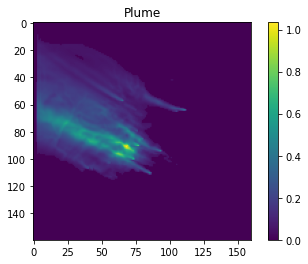

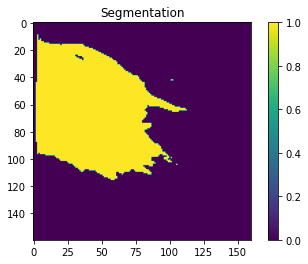

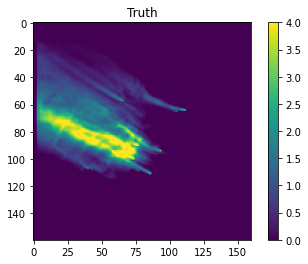

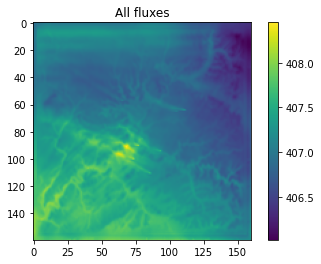

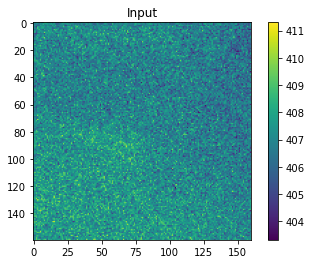

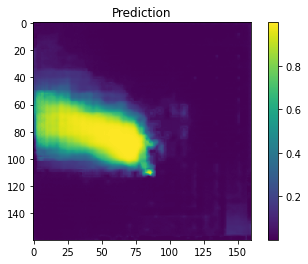

In [115]:

print(model.compute_loss(y=y_valid[idx:idx+1], y_pred=pred_valid[idx:idx+1]).numpy())

plt.figure()
plt.imshow(np.squeeze(data.y.trace_valid[idx]))
plt.colorbar()
plt.title("Plume")
plt.savefig(os.path.join("nb/fig", dataset + "-trace.png"), transparent=True)

plt.figure()
plt.imshow(np.squeeze(np.where(data.y.trace_valid[idx]>0.05,1,0)))
plt.colorbar()
plt.title("Segmentation")
plt.savefig(os.path.join("nb/fig", dataset + "-seg.png"), transparent=True)

plt.figure()
plt.imshow(np.squeeze(data.y.valid[idx]))
plt.colorbar()
plt.title("Truth")
plt.savefig(os.path.join("nb/fig", dataset + "-truth.png"), transparent=True)

plt.figure()
plt.imshow(np.squeeze(xco2_valid[idx]))
plt.colorbar()
plt.title("All fluxes")
plt.savefig(os.path.join("nb/fig", dataset + "-xco2.png"), transparent=True)


plt.figure()
plt.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[0][idx])))
plt.colorbar()
plt.title("Input")
plt.savefig(os.path.join("nb/fig", dataset + "-input.png"), transparent=True)

plt.figure()
plt.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[0][idx], 0))[0]))
plt.colorbar()
plt.title("Prediction")
plt.savefig(os.path.join("nb/fig", dataset + "-pred.png"), transparent=True)


### Real save

0.21131533


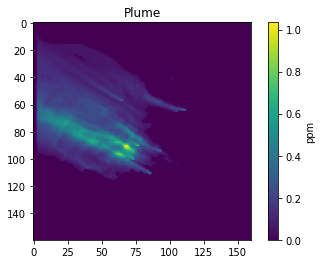

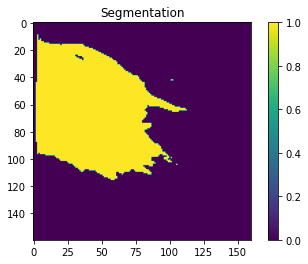

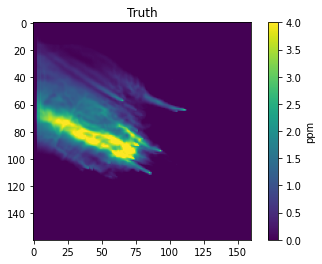

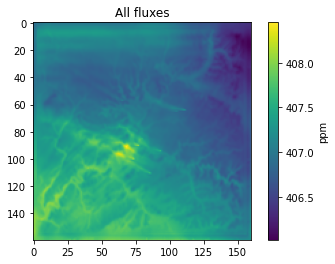

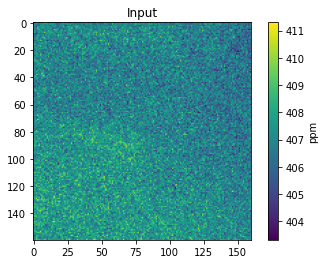

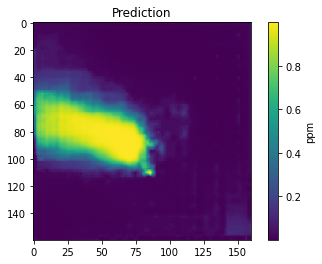

In [120]:
print(model.compute_loss(y=y_valid[idx:idx+1], y_pred=pred_valid[idx:idx+1]).numpy())

plt.figure()
plt.imshow(np.squeeze(data.y.trace_valid[idx]))
cbar = plt.colorbar()
plt.title("Plume")
cbar.set_label('ppm')
plt.savefig(os.path.join("nb/fig", dataset + "-trace%s.png"%idx), transparent=True)

plt.figure()
plt.imshow(np.squeeze(np.where(data.y.trace_valid[idx]>0.05,1,0)))
plt.colorbar()
plt.title("Segmentation")
plt.savefig(os.path.join("nb/fig", dataset + "-seg%s.png"%idx), transparent=True)

plt.figure()
plt.imshow(np.squeeze(data.y.valid[idx]))
cbar = plt.colorbar()
plt.title("Truth")
cbar.set_label('ppm')
plt.savefig(os.path.join("nb/fig", dataset + "-truth%s.png"%idx), transparent=True)

plt.figure()
plt.imshow(np.squeeze(xco2_valid[idx]))
cbar = plt.colorbar()
plt.title("All fluxes")
cbar.set_label('ppm')
plt.savefig(os.path.join("nb/fig", dataset + "-xco2%s.png"%idx), transparent=True)

plt.figure()
plt.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[0][idx])))
cbar = plt.colorbar()
plt.title("Input")
cbar.set_label('ppm')
plt.savefig(os.path.join("nb/fig", dataset + "-input%s.png"%idx), transparent=True)

plt.figure()
plt.imshow(np.squeeze(model(tf.expand_dims(data.x.valid[0][idx], 0))[0]))
cbar = plt.colorbar()
plt.title("Prediction")
cbar.set_label('ppm')
plt.savefig(os.path.join("nb/fig", dataset + "-pred%s.png"%idx), transparent=True)